### Task 0 data ingestion


In [6]:
import duckdb
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()
    films = conn.sql("FROM film;").df()

films.head(3)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00


In [7]:
films.columns

Index(['film_id', 'title', 'description', 'release_year', 'language_id',
       'original_language_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'last_update'],
      dtype='object')

### Task 1 - EDA in python

### a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [8]:
def query_sakila(query: str, duckdb_path="data/sakila.duckdb"):
    with duckdb.connect(duckdb_path) as conn:
        df = conn.sql(query=query).df()

        return df

query_sakila("""SELECT title, length
                FROM film
                WHERE length > 180
                ORDER BY length DESC;

""")


,title,length
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185
5,GANGS PRIDE,185
6,HOME PITY,185
7,SOLDIERS EVOLUTION,185
8,POND SEATTLE,185
9,MUSCLE BRIGHT,185


b) Which movies have the word "love" in its title? Show the following columns
 title
 rating
 length
 description

In [9]:
query_sakila("SELECT title, rating, length, description FROM films WHERE title ILIKE '%love%';") 

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


 c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and
 longest movie length

In [10]:
query_sakila( 
    """SELECT MIN(length) as min_length, 
    MAX(length) as max_lenght, 
    MEDIAN(length) as med_length,
    AVG(length) as avg_length,
    FROM films

    """
)

,min_length,max_lenght,med_length,avg_length
0,46,185,114.0,115.272


d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can
 keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.

In [11]:
query_sakila(
    """SELECT title, 
    rental_rate,
    rental_duration,
    rental_rate/rental_duration as price_per_day
    FROM films
    ORDER BY price_per_day DESC
    LIMIT 10;


""")

,title,rental_rate,rental_duration,price_per_day
0,AMERICAN CIRCUS,4.99,3,1.663333
1,BACKLASH UNDEFEATED,4.99,3,1.663333
2,BILKO ANONYMOUS,4.99,3,1.663333
3,BEAST HUNCHBACK,4.99,3,1.663333
4,CARIBBEAN LIBERTY,4.99,3,1.663333
5,AUTUMN CROW,4.99,3,1.663333
6,CASPER DRAGONFLY,4.99,3,1.663333
7,ACE GOLDFINGER,4.99,3,1.663333
8,BEHAVIOR RUNAWAY,4.99,3,1.663333
9,CASUALTIES ENCINO,4.99,3,1.663333


e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have
 played in.

In [12]:
query_sakila(
    """SElECT a.first_name, a.last_name, count(film_id) AS movie_count
    FROM actor a 
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY  movie_count DESC
    LIMIT 10;

"""
)

,first_name,last_name,movie_count
0,GINA,DEGENERES,42
1,WALTER,TORN,41
2,MARY,KEITEL,40
3,MATTHEW,CARREY,39
4,SANDRA,KILMER,37
5,SCARLETT,DAMON,36
6,HENRY,BERRY,35
7,UMA,WOOD,35
8,VAL,BOLGER,35
9,ANGELA,WITHERSPOON,35


 f) Now it's time for you to choose your own question to explore the sakila database! Write down 3-5
 questions you want to answer and then answer them using pandas and duckdb.

Qustion1 Which customers have rented the most films, and how many films have they rented top 10?

In [13]:
query_sakila("""SELECT 
             c.customer_id, 
             c.first_name, 
             c.last_name,
             count(r.rental_id) AS rental_count
             FROM customer c 
             JOIN rental r 
             ON c.customer_id = r.customer_id
             GROUP BY 
             c.customer_id,
             c.first_name, 
             c.last_name 
             ORDER BY rental_count DESC
             LIMIT 10;


""")

,customer_id,first_name,last_name,rental_count
0,148,ELEANOR,HUNT,46
1,526,KARL,SEAL,45
2,144,CLARA,SHAW,42
3,236,MARCIA,DEAN,42
4,75,TAMMY,SANDERS,41
5,197,SUE,PETERS,40
6,469,WESLEY,BULL,40
7,468,TIM,CARY,39
8,178,MARION,SNYDER,39
9,137,RHONDA,KENNEDY,39


Qustion2 To find the customers who has spent the most money top 10?

In [14]:
query_sakila("""SELECT 
             c.customer_id,
             c.first_name || ' ' || c.last_name AS customer,
             '$' || printf('%.2f', SUM(p.amount)) AS total_amount_usd
             FROM customer c 
             JOIN payment p 
             ON  c.customer_id = p.customer_id
             GROUP BY 
             c.customer_id,
             c.first_name,
             c.last_name
             ORDER BY SUM(p.amount) DESC
             LIMIT 10;

"""

)

,customer_id,customer,total_amount_usd
0,526,KARL SEAL,$221.55
1,148,ELEANOR HUNT,$216.54
2,144,CLARA SHAW,$195.58
3,137,RHONDA KENNEDY,$194.61
4,178,MARION SNYDER,$194.61
5,459,TOMMY COLLAZO,$186.62
6,469,WESLEY BULL,$177.60
7,468,TIM CARY,$175.61
8,236,MARCIA DEAN,$175.58
9,181,ANA BRADLEY,$174.66


Qustion3 Select each customer together with their city and address, calculate the total amount they have paid, format that total as US dollars, group the results by customer and city, and then return the 10 customers with the highest total payments.

In [15]:
query_sakila("""SELECT 
             c.customer_id,
             c.first_name || ' ' || c.last_name AS customer,
             ci.city_id,
             a.address_id,
             '$' || printf('%.2f', SUM(p.amount)) AS total_amount_usd
             FROM 
             customer c
             JOIN payment p ON c.customer_id = p.customer_id
             JOIN address a ON c.address_id = a.address_id
             JOIN city ci ON a.city_id = ci.city_id
             GROUP BY
             c.customer_id,
             c.first_name,
             c.last_name,
             ci.city_id,
             a.address_id
             ORDER BY 
                SUM(p.amount) DESC
             LIMIT 10;



""")

,customer_id,customer,city_id,address_id,total_amount_usd
0,526,KARL SEAL,101,532,$221.55
1,148,ELEANOR HUNT,442,152,$216.54
2,144,CLARA SHAW,340,148,$195.58
3,137,RHONDA KENNEDY,29,141,$194.61
4,178,MARION SNYDER,456,182,$194.61
5,459,TOMMY COLLAZO,423,464,$186.62
6,469,WESLEY BULL,388,474,$177.60
7,468,TIM CARY,78,473,$175.61
8,236,MARCIA DEAN,527,240,$175.58
9,181,ANA BRADLEY,333,185,$174.66


TASK 2 

a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them
with special offers. Create a bar chart showing the top 5 customers by total spend.


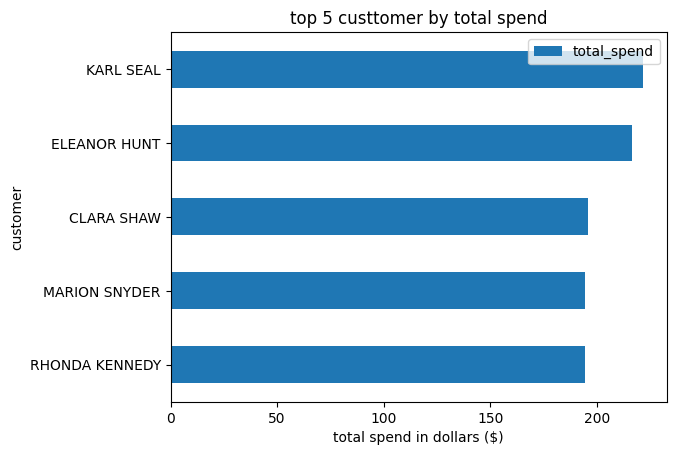

In [16]:
top5=query_sakila("""SELECT 
             c.customer_id,
             c.first_name || ' ' || c.last_name AS customer,
            SUM(p.amount) AS total_spend 
             FROM customer c 
             JOIN payment p 
             ON  c.customer_id = p.customer_id
             GROUP BY 
             c.customer_id,
             c.first_name,
             c.last_name
             ORDER BY SUM(p.amount) DESC
             LIMIT 5;

""")

ax = top5.plot(
    kind="barh",
    x="customer",
    y="total_spend",
    title="top 5 custtomer by total spend",
    xlabel="total spend in dollars ($)",
)

ax.invert_yaxis()



b) How much money does each film category bring in? Make a bar chart showing total revenue per film
category.

In [17]:
query_sakila("""SELECT 



""")

ParserException: Parser Error: SELECT clause without selection list